In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [2]:
def make_data(n=10000):
    x, _ = make_swiss_roll(n_samples=n, noise=0.5)
    x = x[:, [0, 2]]  # primeras dos dimensiones de cada muestra.
    x = (x - x.mean()) / x.std()
    return torch.tensor(x, dtype=torch.float32)

data_points = make_data()
dataset = TensorDataset(data_points)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)

In [3]:
class DDPM:
    def __init__(self, diffusion_steps=100, min_beta=1e-4, max_beta=0.02, device='mps'):
        self.device = device
        self.diffusion_steps = diffusion_steps
        self.beta = torch.linspace(min_beta, max_beta, diffusion_steps, device=self.device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
    def _add_noise(self, x, t):
        """
        Args:
            x: [batch_size, input_dim]
            t: [batch_size]
        Returns:
            x_t: [batch_size, input_dim]
            epsilon: [batch_size, input_dim]
        """
        
        epsilon = torch.randn_like(x)
        t = t[:, None]
        x_t = self.alpha_bar[t].sqrt() * x + (1-self.alpha_bar[t]).sqrt() * epsilon
        return x_t, epsilon

    def train_model(self, model, dataloader, optimizer, epochs):

        model.to(self.device)
        model.train()
        loss_fn = nn.MSELoss()

        for epoch in range(epochs):
            for x, in dataloader:
                x = x.to(self.device)
                batch_size, input_dim = x.shape

                t = torch.randint(self.diffusion_steps, size=[batch_size], device=self.device)
                x_t, epsilon = self._add_noise(x, t)
                epsilon_pred = model(x_t, t)
                loss = loss_fn(epsilon_pred, epsilon)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    def generate_samples(self, model, num_samples):
        model.to(self.device)
        model.eval()
        
        with torch.no_grad():
            x = torch.randn(num_samples, model.input_dim, device=self.device)
            
            for t in reversed(range(self.diffusion_steps)):
                t_batch = torch.full([num_samples], t, device=self.device)
                epsilon_pred = model(x, t_batch)
                
                factor1 = 1 / self.alpha[t].sqrt()
                factor2 = (1 - self.alpha[t]) / (1 - self.alpha_bar[t]).sqrt()
                factor3 = torch.sqrt((1 - self.alpha[t]) * (1 - self.alpha_bar[t-1]) / (1 - self.alpha_bar[t]))
                
                z = torch.randn_like(x) if t > 0 else 0
                x = factor1 * (x - factor2 * epsilon_pred) + factor3 * z
        
        return x

In [4]:
class DiffusionNetwork(nn.Module):
    def __init__(self, input_dim, n_layers=6, hidden_dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim), nn.ReLU(),
            *[nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU()) for _ in range(n_layers - 2)],
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        return self.model(torch.cat([x, t[:, None]], dim=1))

# Red neuronal y optimizador:
model = DiffusionNetwork(input_dim=2)
optimizer = optim.Adam(model.parameters())

# Entrenamiento:
ddpm = DDPM()
ddpm.train_model(model, dataloader, optimizer, epochs=1000)

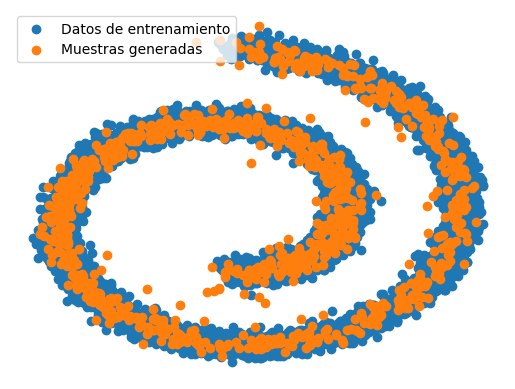

In [5]:
def plot_samples(train_points, new_points):
    new_points = new_points.cpu()
    plt.scatter(train_points[:, 0], train_points[:, 1], label='Datos de entrenamiento')
    plt.scatter(new_points[:, 0], new_points[:, 1], label='Muestras generadas')
    plt.legend()
    plt.axis('off')
    plt.show()

# Generación y visualización de muestras:
samples = ddpm.generate_samples(model, 1000)
plot_samples(data_points, samples)